In [ ]:
# Baixi Guo, Jason Limfueco, Laura Ngo, Pooja Panchal

In [ ]:
import pyspark
from pyspark.sql import SparkSession

Let's set up our spark session and rationale before we attend to uploading and partitiioning our data.
It’s a collection of Amazon customer reviews and metadata for Sports category products sold in the U.S.,
with star ratings, review text, and related fields, and it is part of a larger Amazon US customer reviews dataset spanning many product types.

In [ ]:
# Initializing our spark
"""
Formula ==
Executor instances = Total Cores - 1
Executor memory = (Total Memory - Driver Memory) / Executor Instances

Executor instances = 32 − 1 = 31
Executor memory = (128 − 2) / 31 ≈ 4.06GB → 4GB per executor

NOTE:
The execution size was the driving factor for this set based on previous experience \
working with social media analysis.
Given the 54GB size of the Amazon dataset, this configuration provides:

-High parallelism (31 concurrent tasks)
-Sufficient executor memory to reduce shuffle spill
-Balanced memory distribution to prevent executor OOM during aggregations

The 4GB executor size was chosen to provide adequate memory headroom for groupBy and \
aggregation operations without creating excessively large JVM heaps, \
which can increase garbage collection overhead.
"""
spark = (
    SparkSession.builder
    .appName('amazon_set')
    .config('spark.driver.memory', '2g')
    .config('spark.executor.instances', '31')
    .config('spark.executor.memory', '4g')
    .config('spark.executor.cores', '1')
    .getOrCreate()
)

In [ ]:
# CHECK IF OUR SPARK SHOWS SOME SORT OF ACTIVE EXECUTOR SET UP
import requests
import pandas as pd # RECALL we're going to use spark not pandas

# Get the active Spark Context and URL
sc = spark.sparkContext
url = f"{sc.uiWebUrl}/api/v1/applications/{sc.applicationId}/executors"

# Fetch the executor data from the API
response = requests.get(url)
executors = response.json()

# Format into a readable DataFrame
df = pd.DataFrame(executors)[['id', 'totalCores', 'maxMemory', 'activeTasks', 'isActive']]
df['maxMemory_GB'] = (df['maxMemory'] / (1024**3)).round(2)
df

,id,totalCores,maxMemory,activeTasks,isActive,maxMemory_GB
0,driver,32,1099746508,0,True,1.02


In [ ]:
from pyspark.sql.types import (
    StructType, StructField,
    StringType, IntegerType
)

In [ ]:
import kagglehub
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Download dataset (cached by kagglehub)
base_dir = kagglehub.dataset_download('cynthiarempel/amazon-us-customer-reviews-dataset')
print('Downloaded to:', base_dir)

# Schema (recommended)
schema = StructType([
    StructField('marketplace', StringType(), True),
    StructField('customer_id', StringType(), True),
    StructField('review_id', StringType(), True),
    StructField('product_id', StringType(), True),
    StructField('product_parent', StringType(), True),
    StructField('product_title', StringType(), True),
    StructField('product_category', StringType(), True),
    StructField('star_rating', IntegerType(), True),
    StructField('helpful_votes', IntegerType(), True),
    StructField('total_votes', IntegerType(), True),
    StructField('vine', StringType(), True),
    StructField('verified_purchase', StringType(), True),
    StructField('review_headline', StringType(), True),
    StructField('review_body', StringType(), True),
    StructField('review_date', StringType(), True),
])

pattern = f'file:{base_dir}/amazon_reviews_us_*_v*.tsv'

reviews_df = (
    spark.read
        .option('header', 'true')
        .option('sep', '\t')
        .schema(schema)
        .csv(pattern)
        .withColumn('source_file', F.input_file_name())
        .withColumn('category', F.regexp_extract('source_file', r'amazon_reviews_us_([^/]+?)_v', 1))
        .filter(F.col('category') != 'multilingual')
        .drop('source_file')
)

reviews_df.select('category', 'star_rating', 'product_id').show(10, truncate=False)

Downloaded to: /home/jlimfueco/.cache/kagglehub/datasets/cynthiarempel/amazon-us-customer-reviews-dataset/versions/9
+--------+-----------+----------+
|category|star_rating|product_id|
+--------+-----------+----------+
|Apparel |4          |B01KL6O72Y|
|Apparel |5          |B01ID3ZS5W|
|Apparel |5          |B01I497BGY|
|Apparel |5          |B01HDXFZK6|
|Apparel |5          |B01G6MBEBY|
|Apparel |5          |B01FWRXN0Y|
|Apparel |5          |B01EXNH1HE|
|Apparel |4          |B01E7OL09O|
|Apparel |5          |B01DXHX81O|
|Apparel |3          |B01DDULIJK|
+--------+-----------+----------+
only showing top 10 rows



In [ ]:
print('Partitions:', reviews_df.rdd.getNumPartitions())

reviews_df.groupBy('category') \
    .count() \
    .orderBy(F.desc('count')) \
    .show(10, truncate=False)

Partitions: 384
+----------------------+-------+
|category              |count  |
+----------------------+-------+
|Wireless              |9002021|
|PC                    |6908554|
|Apparel               |5906333|
|Health_Personal_Care  |5331449|
|Beauty                |5115666|
|Digital_Ebook_Purchase|5101693|
|Video_DVD             |5069140|
|Mobile_Apps           |5033376|
|Toys                  |4864249|
|Sports                |4850360|
+----------------------+-------+
only showing top 10 rows



In [ ]:
reviews_df.printSchema()
print('master:', spark.sparkContext.master)
print('partitions:', reviews_df.rdd.getNumPartitions())

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- category: string (nullable = false)

master: local[*]
partitions: 384


In [ ]:
# Let's... see how big this data is!
reviews_df.count()

102899354

In [ ]:
reviews_df.describe().show()

+-------+-----------+--------------------+--------------+--------------------+-------------------+--------------------+--------------------+-----------------+------------------+-----------------+---------+-----------------+--------------------+--------------------+-----------+---------+
|summary|marketplace|         customer_id|     review_id|          product_id|     product_parent|       product_title|    product_category|      star_rating|     helpful_votes|      total_votes|     vine|verified_purchase|     review_headline|         review_body|review_date| category|
+-------+-----------+--------------------+--------------+--------------------+-------------------+--------------------+--------------------+-----------------+------------------+-----------------+---------+-----------------+--------------------+--------------------+-----------+---------+
|  count|  102899354|           102899354|     102899354|           102899354|          102899354|           102899354|           102897

In [ ]:
# Let's play with the data. What are our most popular products?

top_categories = (
    reviews_df
    .groupBy('product_category')
    .agg(F.count('*').alias('review_count'))
    .orderBy(F.desc('review_count'))
    .limit(10)
)

top_categories.show(truncate=False)

+----------------------+------------+
|product_category      |review_count|
+----------------------+------------+
|Wireless              |9001881     |
|PC                    |6908551     |
|Apparel               |5906322     |
|Health & Personal Care|5331215     |
|Beauty                |5115452     |
|Digital_Ebook_Purchase|5101676     |
|Video DVD             |5069136     |
|Mobile_Apps           |5033376     |
|Toys                  |4864243     |
|Sports                |4849563     |
+----------------------+------------+



In [ ]:
# How many sports products do we have?
sports_count = (
    reviews_df
    .filter(F.col('product_category') == 'Sports')
    .count()
)

print(f"Total Sports reviews: {sports_count}")

Total Sports reviews: 4849563


In [ ]:
# How about if we check for the unique sports products by product_id

distinct_sports_products = (
    reviews_df
    .filter(F.col('product_category') == 'Sports')
    .select('product_id')
    .distinct()
    .count()
)

print(f'Distinct Sports products: {distinct_sports_products}')

Distinct Sports products: 1046129


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Let's focus on a sports specific data frame for plotting.
# We'll scale this up for our own needs with all the data in the future
sports_df = (
    reviews_df
        .filter(lower(col('product_category')) == 'sports')
)
# materialize cache (important)
sports_df.cache()
# check the sports_df row counts
sports_df.count()

4850360

In [ ]:
top10_products = (sports_df.groupBy('product_id')
                  .count()
                  .orderBy(F.desc('count'))
                  .limit(10))
top10_products.show(truncate=False)

+----------+-----+
|product_id|count|
+----------+-----+
|B001HBHNHE|7405 |
|7245456313|3693 |
|B00FX0S4DC|3051 |
|B000UVVX28|3006 |
|B002QZ1RS6|2922 |
|B003TJH3LI|2823 |
|B005M1P85O|2786 |
|B001EJMS6K|2560 |
|B00178CS4K|2299 |
|B007595TKU|2278 |
+----------+-----+



In [ ]:
top10_pd = top10_products.toPandas()

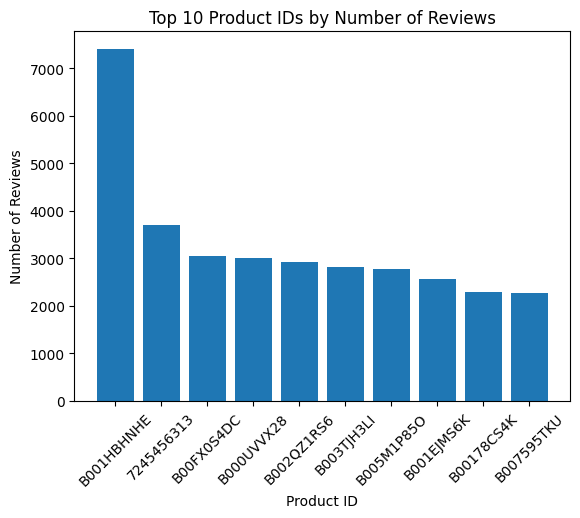

In [ ]:
plt.figure()
plt.bar(top10_pd['product_id'], top10_pd['count'])
plt.xticks(rotation = 45)
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Product IDs by Number of Reviews')
plt.show()

In [ ]:
from pyspark.sql import functions as F

sports_df_clean = sports_df.withColumn(
    "star_rating_int",
    F.expr("try_cast(star_rating as int)")
)

In [ ]:
sports_df_clean = sports_df_clean.filter(
    F.col("star_rating_int").isNotNull()
)

In [ ]:
avg_rating = (
    sports_df_clean.groupBy("product_id")
    .agg(
        F.avg("star_rating_int").alias("avg_rating"),
        F.count("*").alias("num_reviews")
    )
    .filter(F.col("num_reviews") > 100)
    .orderBy(F.desc("num_reviews"))
    .limit(10)
)

In [ ]:
avg_pd = avg_rating.toPandas()

In [ ]:
scatter_df = (
    sports_df
    .withColumn("star_rating_int", F.expr("try_cast(star_rating as int)"))
    .filter(F.col("star_rating_int").isNotNull())
    .groupBy("product_id")
    .agg(
        F.avg("star_rating_int").alias("avg_rating"),
        F.count("*").alias("num_reviews")
    )
    .filter(F.col("num_reviews") > 50)  # avoid tiny sample noise
)

In [ ]:
scatter_pd = scatter_df.toPandas()

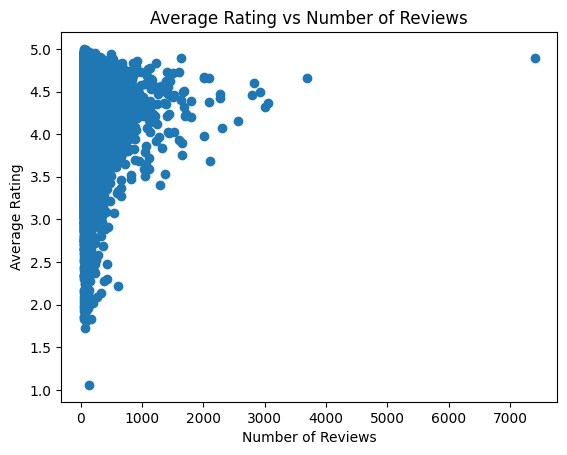

In [ ]:
plt.figure()
plt.scatter(scatter_pd['num_reviews'], scatter_pd['avg_rating'])
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.title('Average Rating vs Number of Reviews')
plt.show()

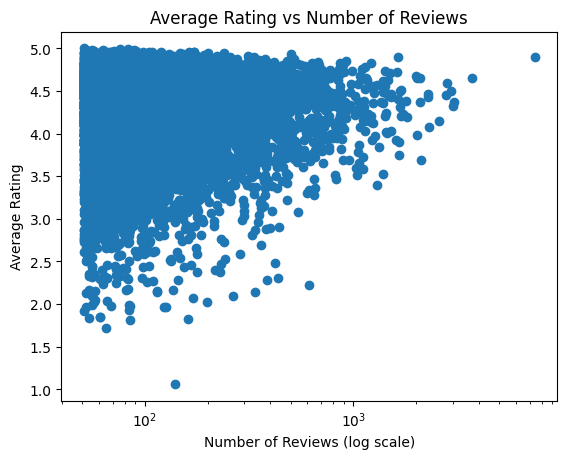

In [ ]:
plt.figure()
plt.scatter(scatter_pd['num_reviews'], scatter_pd['avg_rating'])
plt.xscale('log')
plt.xlabel('Number of Reviews (log scale)')
plt.ylabel('Average Rating')
plt.title('Average Rating vs Number of Reviews')
plt.show()